# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using Visible region data only



In [81]:
# Install keras
# !pip install keras==2.1.6

In [82]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [83]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [84]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


In [85]:
len(df['book'].unique())

60

# Data visualization and pre-processing

## Handling missing values

In [86]:
# Shape of the dataframe
df.shape

(248756, 4)

In [87]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

In [88]:
# Replacing all missing values of K with zero
df['k'].fillna(0, inplace = True)

In [89]:
# Confirming we have handled NUll k values
df.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

## One hot encoding targets (Classes of organic compounds) with integers

In [90]:
# Get unique values of classes, sort them to ensure always the same order

# encode class values as integers
encoder = LabelEncoder()
df['book'] = encoder.fit_transform(df['book'])

# This is our dictionary for decoding the labels 
# (Same order as indices of probabilities from NN prediction)
classes_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_,))
classes_dictionary = str(classes_dictionary) 

# Write our dictionary to a json file
import json
	
# Write to current runtime
with open("classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

# Write to google drive
with open("/content/drive/MyDrive/colab_data/DLOrganicClassifierData/classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [91]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,47,7.64511,1.43477,0.022300
1,28,1.62920,1.36104,0.000052
2,28,21.07840,1.42141,0.028228
3,18,1.78328,1.33364,0.000006
4,45,2.74283,1.47299,0.000239


In [92]:
len(df['book'].unique())

60

In [93]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
50641,49,4.22167,1.51436,0.000358,Far_IR
171629,22,2.03451,1.34403,0.000070,IR
16919,45,1.36366,1.47456,0.000014,Near_IR


Let’s see how many of each class is in our data set

In [94]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

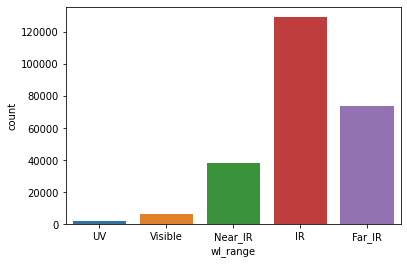

In [95]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [96]:
# Lets select only rows within Visible region
df = df.loc[df['wl_range'].isin(['Visible'])]
df.head()

,book,wl,n,k,wl_range
19,3,0.430000,1.556250,1.960000e-06,Visible
60,56,0.530300,1.000448,0.000000e+00,Visible
83,22,0.503145,1.364790,8.791130e-08,Visible
157,11,0.472578,1.511098,3.053000e-03,Visible
169,25,0.619920,1.470000,0.000000e+00,Visible


In [97]:
# Describe new df with only Visible region data
df.describe()

,book,wl,n,k
count,6268.000000,6268.000000,6268.000000,6268.000000
mean,25.435067,0.567108,1.407649,0.000096
std,16.614124,0.092084,0.127758,0.000496
min,0.000000,0.400729,1.000440,0.000000
25%,9.000000,0.491686,1.372142,0.000000
50%,22.000000,0.567600,1.414033,0.000000
75%,39.000000,0.635400,1.486042,0.000000
max,59.000000,0.750000,1.696493,0.003804


In [98]:
df.shape

(6268, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [99]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (6268, 3)
Targets (y):  (6268,)


## Normalizing Data


In [100]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
117097,-1.554110,0.184339,-0.193046
231471,-0.236831,0.475739,-0.193046
224460,-1.326057,0.095625,-0.193046
222383,0.179094,-0.383587,-0.193046
192993,0.992484,-3.187341,-0.193046
94248,-0.716829,0.172845,-0.193046
198375,1.182529,0.599985,-0.193046
4945,-1.296736,-0.457656,-0.193046
43303,0.520946,-0.370772,-0.192877
143459,0.592848,-0.235800,-0.193046


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [101]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [102]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (5014, 3)
y - Train shape:  (5014,)
X - Test shape:  (1254, 3)
y - Test shape:  (1254,)


In [103]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 60 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

60


In [104]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 300

In [105]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                200       
                                                                 
 dense_7 (Dense)             (None, 100)               5100      
                                                                 
 dense_8 (Dense)             (None, 60)                6060      
                                                                 
Total params: 11,360
Trainable params: 11,360
Non-trainable params: 0
_________________________________________________________________


In [106]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/300
110/110 - 1s - loss: 3.4918 - accuracy: 0.1998 - val_loss: 2.8854 - val_accuracy: 0.2419 - 802ms/epoch - 7ms/step
Epoch 2/300
110/110 - 0s - loss: 2.5203 - accuracy: 0.2918 - val_loss: 2.2487 - val_accuracy: 0.3216 - 251ms/epoch - 2ms/step
Epoch 3/300
110/110 - 0s - loss: 2.1054 - accuracy: 0.3371 - val_loss: 1.9892 - val_accuracy: 0.3495 - 248ms/epoch - 2ms/step
Epoch 4/300
110/110 - 0s - loss: 1.9022 - accuracy: 0.3776 - val_loss: 1.8584 - val_accuracy: 0.3502 - 245ms/epoch - 2ms/step
Epoch 5/300
110/110 - 0s - loss: 1.7789 - accuracy: 0.3890 - val_loss: 1.7399 - val_accuracy: 0.3767 - 250ms/epoch - 2ms/step
Epoch 6/300
110/110 - 0s - loss: 1.6943 - accuracy: 0.3973 - val_loss: 1.6798 - val_accuracy: 0.3734 - 235ms/epoch - 2ms/step
Epoch 7/300
110/110 - 0s - loss: 1.6276 - accuracy: 0.4146 - val_loss: 1.6607 - val_accuracy: 0.4086 - 229ms/epoch - 2ms/step
Epoch 8/300
110/110 - 0s - loss: 1.5746 - accuracy: 0.4278 - val_loss: 1.6021 - val_accuracy: 0.4093 - 241ms/epoch - 2

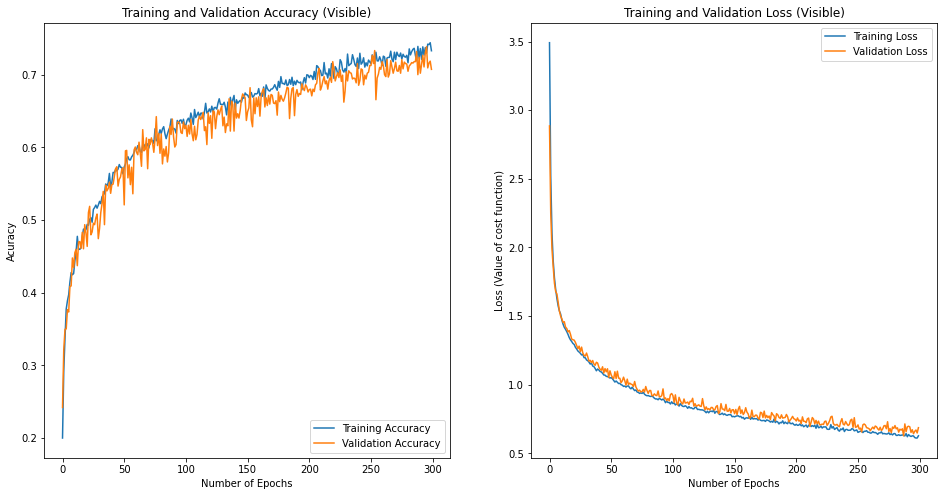

In [112]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Visible)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Visible)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [113]:
# # Save model as h5 (keras model)
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Visible_organic_model.h5')

In [114]:
# # Save the entire model as a SavedModel in drive
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Visible_organic_model') 

# Model Evaluation

In [110]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.6921849846839905
The test Loss is:  0.7102802991867065


In [111]:
# Classification report
y_pred = model.predict(x_test) # Whole test set
classes = encoder.classes_.tolist() # Convert our array of labels (classes) to list

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names = classes, labels = range (60) ))

                                                  precision    recall  f1-score   support

    (C10H8O4)n (Polyethylene terephthalate, PET)       0.67      0.75      0.71         8
                 (C16H14O3)n (Polycarbonate, PC)       0.60      0.53      0.56        17
  (C2ClF3)n (Polychlorotrifluoroethylene, PCTFE)       0.00      0.00      0.00         0
             (C2H3Cl)n (Polyvinyl chloride, PVC)       0.78      1.00      0.88         7
          (C2H4)n (Polyethylene, PE, HDPE, LDPE)       0.00      0.00      0.00         0
               (C2H4O)n (Polyvinyl alcohol, PVA)       0.80      0.63      0.71        19
         (C2H6OSi)n (Polydimethylsiloxane, PDMS)       0.84      0.80      0.82       202
             (C37H24O6N2)n (Polyetherimide, PEI)       0.88      1.00      0.93         7
                (C3H4O2)n (Polylactic acid, PLA)       0.65      0.95      0.77        21
     (C5H8O2)n (Poly(methyl methacrylate), PMMA)       0.83      0.72      0.77        68
         